In this part of the project, we will start by performing some analysis on the features to see how the differ between the two sets, then we will run a model on them and see how well it performs.

## Features Analysis

After computing the various features for the True and Fake news datasets, we will now plot our results to compare the tendency of each feature in the Fake news vs the True news. This will help us see if the feature is relevant in detecting that type of news or not.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.neural_network import MLPClassifier
%matplotlib inline

In [2]:
from scipy import stats
from scipy.stats import levene
import seaborn as sns

In [3]:
#remove warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
#set the features data folder name 
FEATURES_FOLDER = 'news_features'

#load the Fake news dataframe
df_Fake_text =  pd.read_csv(os.path.join(FEATURES_FOLDER,'df_Fake_text.csv'))

In [5]:
#rename some columns because previous names are less appealing 
df_Fake_text.rename(columns = {'numSentence': 'nb_sentences', 'numWords': 'nb_words', 'totSentiment': 'tot_sentiments' , 'avgSentiment': 'avg_sentiment'}, inplace = True)

In [6]:
#print some entries
df_Fake_text.head()

,text,nb_sentences,nb_words,tot_sentiments,avg_sentiment,positive_Sentiment,negative_Sentiment,neutral_Sentiment,parses,politeness,premises_conclusions,subjectivity,polarity,comparaison,contingency,expansion
0,donald trump just couldn t wish all americans ...,27.0,462.0,52.0,1.925926,7.0,10.0,10.0,['(ROOT\n (S\n (NP\n (NP (JJ donald) ...,0.422506,18,0.592490,0.082463,8,27,50
1,house intelligence committee chairman devin nu...,10.0,308.0,12.0,1.200000,0.0,8.0,2.0,['(ROOT\n (S\n (NP (NN house) (NN intellig...,0.455562,21,0.334098,-0.005004,7,16,40
2,"on friday, it was revealed that former milwauk...",25.0,544.0,41.0,1.640000,3.0,12.0,10.0,['(ROOT\n (S\n (PP (IN on)\n (NP (NNP...,0.441890,20,0.542352,0.009671,9,24,47
3,"on christmas day, donald trump announced that ...",17.0,411.0,26.0,1.529412,2.0,10.0,5.0,['(ROOT\n (S\n (PP (IN on)\n (NP (NNP...,0.470385,22,0.372581,0.009140,13,18,48
4,pope francis used his annual christmas day mes...,19.0,420.0,33.0,1.736842,6.0,11.0,2.0,['(ROOT\n (S\n (NP (NN pope) (NNS francis)...,0.456240,25,0.495222,-0.011722,4,26,48


In [7]:
##load the True news dataframe
df_True_text =  pd.read_csv(os.path.join(FEATURES_FOLDER,'df_True_text2.csv' ))

In [8]:
#rename some columns because previous names are less appealing 
df_True_text.rename(columns = {'numSentence': 'nb_sentences', 'numWords': 'nb_words', 'totSentiment': 'tot_sentiments' , 'avgSentiment': 'avg_sentiment'}, inplace = True)

In [9]:
#print some entries
df_True_text.head()

,text,nb_sentences,nb_words,tot_sentiments,avg_sentiment,positive_Sentiment,negative_Sentiment,neutral_Sentiment,parses,politeness,premises_conclusions,subjectivity,polarity,comparaison,contingency,expansion
0,the head of a conservative republican faction ...,31.0,730.0,63.0,2.032258,10.0,9.0,12.0,['(ROOT\n (S\n (NP\n (NP\n (NP...,0.456962,45,0.410250,0.037083,15,26,82
1,transgender people will be allowed for the fir...,22.0,614.0,38.0,1.727273,4.0,10.0,8.0,['(ROOT\n (S\n (S\n (NP (JJ transgend...,0.458206,23,0.308401,0.044354,10,25,57
2,the special counsel investigation of links bet...,19.0,452.0,39.0,2.052632,5.0,4.0,10.0,['(ROOT\n (S\n (S\n (NP\n (NP ...,0.449653,23,0.316798,0.115930,9,20,49
3,trump campaign adviser george papadopoulos tol...,16.0,374.0,30.0,1.875000,4.0,6.0,6.0,['(ROOT\n (S\n (S\n (NP (NN trump) (N...,0.461039,28,0.306569,0.035968,8,22,51
4,president donald trump called on the u.s. post...,45.0,827.0,77.0,1.711111,8.0,21.0,16.0,['(ROOT\n (S\n (NP\n (NP (NN presiden...,0.450035,47,0.398611,0.034322,20,34,85


In [10]:
print("shape of the True news dataframe:", df_True_text.shape, "\nshape of the Fake news dataframe:", df_Fake_text.shape)

shape of the True news dataframe: (21391, 16) 
shape of the Fake news dataframe: (22732, 16)


To keep the two datasets matched, we will ignore the last entries in the Fake news dataframe to get the same length for the two sets.

In [11]:
df_Fake_text= df_Fake_text.iloc[ : len(df_True_text)]

In [12]:
print("shape of the True news dataframe:", df_True_text.shape, "\nshape of the Fake news dataframe:", df_Fake_text.shape)

shape of the True news dataframe: (21391, 16) 
shape of the Fake news dataframe: (21391, 16)


In [13]:
#method to compute bootstrapped standard errors 
#It's a modified version of the method we used in Becoming a DataVizard exercise
def bootstrap_std(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)
        
    #return the standard deviation of the means
    return np.std(means)

### Sentiments Plots 

#### Stanford coreNLP

The coreNLP sentiment analyser computes the sentiment based on how words compose the meaning of longer phrases and not on words independently. We computed the sentiments of each sentence using it and then took the average of the sentences sentiments to get the sentiments of a given news. This was performed on 3000 Real and Fake news respectively. Since the news are independent, (we estimate that 3000 is quite representative of the entire dataset).  
We show here average number of Sentiments with coreNLP for 3000 Fake and Real news resepectively.

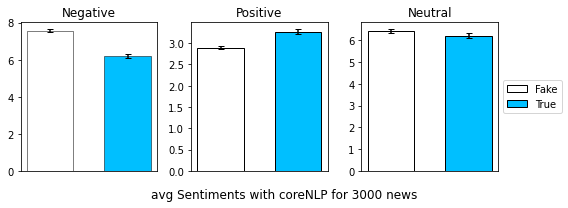

In [14]:
#labels for the plots
labels=['Fake ' , 'True']

#colors
color_Fake = 'white'
color_True= 'deepskyblue'

#distance between the two bars in the plot
distance=0.3

#width of the bar
width = 0.45

#create 3 subplots for the 3 graphs
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8 , 3))

#first plot: negative sentiments

#plot the bar for the avg negative sentiments of the Fake news
ax1.bar(0,
                    np.mean(df_Fake_text['negative_Sentiment'].iloc[:3001]),
                    yerr=bootstrap_std(df_Fake_text['negative_Sentiment'].iloc[:3001], 1000),
                    width=width,
                    label='Fake',
                    color=color_Fake,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
  )

#plot the bar for the avg negative sentiment of the True news
ax1.bar(width+distance ,
                    np.mean(df_True_text['negative_Sentiment'].iloc[:3001]),
                    yerr=bootstrap_std(df_True_text['negative_Sentiment'].iloc[:3001], 1000),
                    width=width,
                    label='True',
                    color=color_True,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
)


#remove x_axis ticks and set the title
ax1.set_xticks([])
ax1.set_title('Negative')



#second plot: positive sentiments

#plot the bar for the avg positive sentiments of the Fake news
ax2.bar(0,
                    np.mean(df_Fake_text['positive_Sentiment'].iloc[:3001]),
                    yerr=bootstrap_std(df_Fake_text['positive_Sentiment'].iloc[:3001],1000),
                    width=width,
                    color=color_Fake,
                    label='Fake',
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )

#plot the bar for the avg positive sentiments of the True news
ax2.bar(width+distance,
                    np.mean(df_True_text['positive_Sentiment'].iloc[:3001]),
                    yerr=bootstrap_std(df_True_text['positive_Sentiment'].iloc[:3001],1000),
                    width=width,
                    color= color_True,
                    label='True' , 
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )

#remove x_axis ticks and set the title
ax2.set_xticks([])
ax2.set_title('Positive')



#Third plot: neutral sentiments

#plot the bar for the avg neutral sentiments of the Fake news
ax3.bar(0,
                    np.mean(df_Fake_text['neutral_Sentiment'].iloc[:3001]),
                    yerr=bootstrap_std(df_Fake_text['neutral_Sentiment'].iloc[:3001],1000),
                    width=width,
                    color=color_Fake,
                    label='Fake',
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )

#plot the bar for the avg neutral sentiments of the True news
ax3.bar(width+distance,
                    np.mean(df_True_text['neutral_Sentiment'].iloc[:3001]),
                    yerr=bootstrap_std(df_True_text['neutral_Sentiment'].iloc[:3001],1000),
                    width=width,
                    color= color_True,
                    label='True' , 
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )
#remove x_axis ticks and set the title
ax3.set_xticks([])
ax3.set_title('Neutral')

#add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#set plot title
fig.suptitle('avg Sentiments with coreNLP for 3000 news', y=0)

plt.tight_layout()
plt.show()

As we can see from these plots, the Fake news have on average more negative sentiments and less positive sentiments than True news. The number of neutral sentiments is close for the two datasets, we will perform a statistical test to check if the diffrence is significant.

In [15]:
print("normal test on neutral sentiments of Fake news:",stats.normaltest(df_Fake_text['neutral_Sentiment'].iloc[:3001]))
print("normal test on neutral sentiments of True news:",stats.normaltest(df_True_text['neutral_Sentiment'].iloc[:3001]))

normal test on neutral sentiments of Fake news: NormaltestResult(statistic=1466.3580418722927, pvalue=0.0)
normal test on neutral sentiments of True news: NormaltestResult(statistic=4773.441281799178, pvalue=0.0)


Both normal tests gave zero p_values, thus the null hypothesis can be rejected. They both come from a normal distribution.  
Now we will check if they have the same variance.

In [16]:
print("variance test:", levene(df_Fake_text['neutral_Sentiment'].iloc[:3001], df_True_text['neutral_Sentiment'].iloc[:3001] ))

variance test: LeveneResult(statistic=42.41117263972351, pvalue=7.997317294010308e-11)


The levene test gave a significant p_value (<0.05), thus the two sets do not have equal variances.    
Since we have two normal distributions with diffrent variances, we use a Welch's t-test.

In [17]:
print("Welch's t-test:", stats.ttest_ind(df_Fake_text['neutral_Sentiment'].iloc[:3001], df_True_text['neutral_Sentiment'].iloc[:3001], equal_var = False))

Welch's t-test: Ttest_indResult(statistic=1.4761405980153088, pvalue=0.1399625570406107)


The Welch's t-test gave a large p_value (>0.05) thus we cannot reject the null hypothesis of identical average values.

#### Text Blob

After some researches, we found that other methods exist to perform sentiment analysis. This alternative method is part of the TextBlob library that allows to compute the polarity of a text. This last, is much less time consuming, thus we were able to compute the polarity of the entire dataset. However note that while the Stanford analyser computes the number of sentiments (very negative, negative, neutral, positive, very positive) on each sentence, the TextBlob method computes the polarity on an entire text and returns a value in the interval [-1, 1] where values under zero represent negative sentiments, values above zero represent positive sentiments and zero is the neutral sentiment.  
After computing the polarity of each news, we split the range [-1, 1] into 5 bins to get the sets of sentiments as we had with the Stanford coreNLP. We present here the number of news by sentiment category



In [18]:
print("the split of the range [-1,1] into 5 bins:", [-1 , -1+0.4, -1+0.4*2 , -1+0.4*3, -1+0.4*4])

the split of the range [-1,1] into 5 bins: [-1, -0.6, -0.19999999999999996, 0.20000000000000018, 0.6000000000000001]


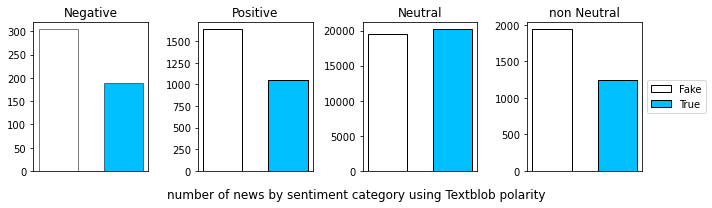

In [19]:
#labels for the plots
labels=['Fake ' , 'True']

#colors
color_Fake = 'white'
color_True= 'deepskyblue'

#distance between the two bars in the plot
distance=0.3

#width of the bar
width = 0.45

#create 4 subplots for the 4 graphs
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10 , 3))

#we divide the polarity into bins to get the set of sentiments: "very negative": 1 , "negative":2  ,"neutral":3 , "positive":4, 
#"very positive":5 fro both True and Fake news
True_polarity_sentiments = pd.cut(df_True_text['polarity'],
                            bins=5,
                            labels=[1, 2, 3, 4, 5])

Fake_polarity_sentiments = pd.cut(df_Fake_text['polarity'],
                            bins=5,
                            labels=[1, 2, 3, 4, 5])


#first plot: negative sentiments

#plot the bar for the avg negative sentiments of the Fake news
ax1.bar(0,
                    len(df_Fake_text[df_Fake_text['polarity']<-1+0.4*2]),
                    width=width,
                    label='Fake',
                    color=color_Fake,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
  )

#plot the bar for the avg negative sentiment of the True news
ax1.bar(width+distance ,
                    len(df_True_text[df_True_text['polarity']<-1+0.4*2]),
                    width=width,
                    label='True',
                    color=color_True,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
)


#remove x_axis ticks and set the title
ax1.set_xticks([])
ax1.set_title('Negative')



#second plot: positive sentiments

#plot the bar for the avg positive sentiments of the Fake news
ax2.bar(0,
                    len(df_Fake_text[-1+0.4*3<df_Fake_text['polarity']]),
                    width=width,
                    color=color_Fake,
                    label='Fake',
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )

#plot the bar for the avg positive sentiments of the True news
ax2.bar(width+distance,
                    len(df_True_text[-1+0.4*3<df_True_text['polarity']]),
                    width=width,
                    color= color_True,
                    label='True' , 
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )

#remove x_axis ticks and set the title
ax2.set_xticks([])
ax2.set_title('Positive')



#Third plot: neutral sentiments

#plot the bar for the avg neutral sentiments of the Fake news
ax3.bar(0,
                    len(df_Fake_text[(-1+0.4*2<=df_Fake_text['polarity'])  & (df_Fake_text['polarity']<=-1+0.4*3)]),
                    width=width,
                    color=color_Fake,
                    label='Fake',
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )

#plot the bar for the avg neutral sentiments of the True news
ax3.bar(width+distance,
                    len(df_True_text[(-1+0.4*2<=df_True_text['polarity'])  & (df_True_text['polarity']<=-1+0.4*3)]),
                    width=width,
                    color= color_True,
                    label='True' , 
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )
#remove x_axis ticks and set the title
ax3.set_xticks([])
ax3.set_title('Neutral')


#Third plot: non neutral sentiments (positive + negative)

#plot the bar for the avg non neutral sentiments of the Fake news
ax4.bar(0,
                    len(df_Fake_text[(-1+0.4*2>df_Fake_text['polarity'])  | (df_Fake_text['polarity']>-1+0.4*3)]),
                    width=width,
                    color=color_Fake,
                    label='Fake',
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )

#plot the bar for the avg non neutral sentiments of the True news
ax4.bar(width+distance,
                    len(df_True_text[(-1+0.4*2>df_True_text['polarity'])  | (df_True_text['polarity']>-1+0.4*3)]),
                    width=width,
                    color= color_True,
                    label='True' , 
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )
#remove x_axis ticks and set the title
ax4.set_xticks([])
ax4.set_title('non Neutral')


#add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#set plot title
fig.suptitle('number of news by sentiment category using Textblob polarity', y=0)

plt.tight_layout()
plt.show()

There are more positive and negative news (considering overall sentiment of the news, the polarity!) among the Fake news then among the True news. The fourth plot confirms that the Fake news are more sentimental than the True news that tend to be more neutral.

Here we plot the average sentiments computed with the Stanford coreNLP and the average polarity computed with the TextBlob.

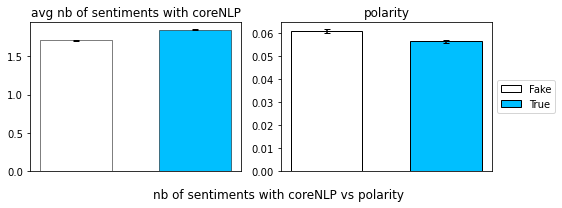

In [20]:
#labels for the plots
labels=['Fake ' , 'True']

#colors
color_Fake = 'white'
color_True= 'deepskyblue'

#distance between the two bars in the plot
distance=0.3

#width of the bar
width = 0.45

#create 2 subplots for the 2 graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8 , 3))

#first plot: avg sentiment

#plot the bar for the avg sentiment of the Fake news
ax1.bar(0,
                    np.mean(df_Fake_text['avg_sentiment']),
                    yerr=bootstrap_std(df_Fake_text['avg_sentiment'], 1000),
                    width=width,
                    label='Fake',
                    color=color_Fake,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
  )

#plot the bar for the avg sentiment of the True news
ax1.bar(width+distance ,
                    np.mean(df_True_text['avg_sentiment']),
                    yerr=bootstrap_std(df_True_text['avg_sentiment'], 1000),
                    width=width,
                    label='True',
                    color=color_True,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
)


#remove x_axis ticks and set the title
ax1.set_xticks([])
ax1.set_title('avg nb of sentiments with coreNLP')



#second plot: avg polarity 

#plot the bar for the avg polarity of the Fake news
ax2.bar(0,
                    np.mean(df_Fake_text['polarity']),
                    yerr=bootstrap_std(df_Fake_text['polarity'],1000),
                    width=width,
                    color=color_Fake,
                    label='Fake',
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )

#plot the bar for the avg polarity of the True news
ax2.bar(width+distance,
                    np.mean(df_True_text['polarity']),
                    yerr=bootstrap_std(df_True_text['polarity'],1000),
                    width=width,
                    color= color_True,
                    label='True' , 
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )

#remove x_axis ticks and set the title
ax2.set_xticks([])
ax2.set_title('polarity')




#add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#set plot title

fig.suptitle('nb of sentiments with coreNLP vs polarity', y=0)

plt.tight_layout()
plt.show()

From the plot on the left, we can see that on average the True news have more positive sentiments than the Fake news, when we work with the coreNLP sentiment analyzer over the 3000 samples. The plot on the right shows that the on average the Fake news are more positive than the True news.

### Talkativeness Plots

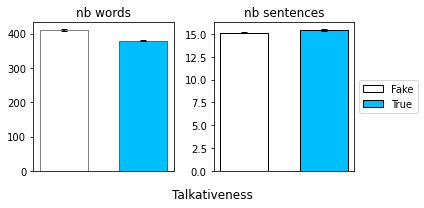

In [21]:
#first plot: nb words

#create two subplots for the two graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6 , 3))

#plot the bar for the avg nb of words of the Fake news
ax1.bar(0,
                    np.mean(df_Fake_text['nb_words']),
                    yerr=bootstrap_std(df_Fake_text['nb_words'], 1000),
                    width=width,
                    label='Fake',
                    color=color_Fake,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
  )

#plot the bar for the avg nb of words of the True news
ax1.bar(width + distance,
                    np.mean(df_True_text['nb_words']),
                    yerr=bootstrap_std(df_True_text['nb_words'], 1000),
                    width=width,
                    label='True',
                    color=color_True,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
)


#remove x_axis ticks and set title
ax1.set_xticks([])
ax1.set_title('nb words')



#second plot: nb sentences

#plot the bar for the avg nb of sentences of the Fake news
ax2.bar(0,
                    np.mean(df_Fake_text['nb_sentences']),
                    yerr=bootstrap_std(df_Fake_text['nb_sentences'],1000),
                    width=width,
                    color=color_Fake,
                    label='Fake',
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )

#plot the bar for the avg nb of sentences of the True news
ax2.bar(width+ distance,
                    np.mean(df_True_text['nb_sentences']),
                    yerr=bootstrap_std(df_True_text['nb_sentences'],1000),
                    width=width,
                    color= color_True,
                    label='True' , 
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )

#remove x_axis ticks and set title
ax2.set_xticks([])
ax2.set_title('nb sentences')

#add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#set plot title
fig.suptitle('Talkativeness', y=0)

plt.tight_layout()
plt.show()

There is a significant diffrence in the average number of words between the two sets, with the Fake news have a higher value on average. However, for the number of sentences, we can see from the plot that the average values are very close. To check if the diffrence is significant we perform a t-test

In [22]:
print("normal test on nb_sentences of Fake news:",stats.normaltest(df_Fake_text['nb_sentences']))
print("normal test on nb_sentences of True news:",stats.normaltest(df_True_text['nb_sentences']))

normal test on nb_sentences of Fake news: NormaltestResult(statistic=21843.577867833174, pvalue=0.0)
normal test on nb_sentences of True news: NormaltestResult(statistic=13989.994437538517, pvalue=0.0)


Both normal tests gave zero p_values, thus the null hypothesis can be rejected. They both come from a normal distribution.
Now we will check if they have the same variance.

In [23]:
print("variance test:", levene(df_Fake_text['nb_sentences'], df_True_text['nb_sentences'] ))

variance test: LeveneResult(statistic=212.60516870239596, pvalue=4.840847311391434e-48)


The levene test gave a significant p_value (<0.05), thus the two sets do not have equal variances.
Since we have two normal distributions with diffrent variances, we use a Welch's t-test.

In [24]:
print("Welch's t-test:", stats.ttest_ind(df_Fake_text['nb_sentences'], df_True_text['nb_sentences'], equal_var = False))

Welch's t-test: Ttest_indResult(statistic=-2.1218912456953176, pvalue=0.03385260504290328)


The Welch's t-test resulted in a significant p_value(<0.05), then we reject the null hypothesis of equal averages. The diffrence in the number of sentences is significant with the True news having more sentences than the Fake ones.

### Politeness plots

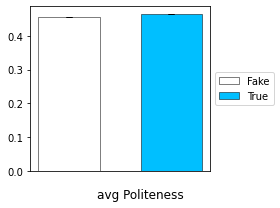

In [25]:
#plot: politeness

#create one subplot
fig, ax1 = plt.subplots(1, 1, figsize=(4 , 3))

#plot the bar for the avg politeness of the Fake news
ax1.bar(0,
                    np.mean(df_Fake_text['politeness']),
                    yerr=bootstrap_std(df_Fake_text['politeness'], 1000),
                    width=width,
                    label='Fake',
                    color=color_Fake,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
  )

#plot the bar for the avg politeness of the True news
ax1.bar(width + distance,
                    np.mean(df_True_text['politeness']),
                    yerr=bootstrap_std(df_True_text['politeness'], 1000),
                    width=width,
                    label='True',
                    color=color_True,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
)


#remove x_axis ticks 
ax1.set_xticks([])


#add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#set plot title
fig.suptitle('avg Politeness', y=0)

plt.tight_layout()
plt.show()

The two types of news seem to have the same average politeness. To check the significance of the diffrence we will perform a t-test.

In [26]:
print("normal test on the politeness of Fake news:",stats.normaltest(df_Fake_text['politeness']))
print("normal test on the politeness of True news:",stats.normaltest(df_True_text['politeness']))

normal test on the politeness of Fake news: NormaltestResult(statistic=3699.5459991581783, pvalue=0.0)
normal test on the politeness of True news: NormaltestResult(statistic=2976.1615525275147, pvalue=0.0)


Both normal tests gave zero p_values, thus the null hypothesis can be rejected. They both come from a normal distribution. Now we will check if they have the same variance.

In [27]:
print("variance test:", levene(df_Fake_text['politeness'], df_True_text['politeness'] ))

variance test: LeveneResult(statistic=246.66957414354937, pvalue=1.9751524271839856e-55)


The levene test gave a significant p_value (<0.05), thus the two sets do not have equal variances. Since we have two normal distributions with diffrent variances, we use a Welch's t-test.

In [28]:
print("Welch's t-test:", stats.ttest_ind(df_Fake_text['politeness'], df_True_text['politeness'], equal_var = False))

Welch's t-test: Ttest_indResult(statistic=-39.50721584180166, pvalue=0.0)


The Welch's t-test resulted in a significant p_value(<0.05), then we reject the null hypothesis of equal averages. The diffrence in the politeness is significant with the True news being more polite than the Fake ones.

To better visualize the subjectivity, we plot here the its distribution over the two sets.

Text(0.5, 0, 'distribution of politeness over the two sets of news')

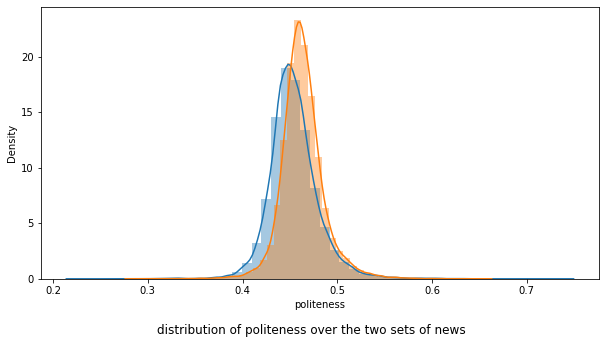

In [29]:
#plot the distribution of politeness over the two sets of news
fig, ax1 = plt.subplots(1, figsize=(10 , 5))
ax1 =sns.distplot(df_Fake_text['politeness'])
ax1= sns.distplot(df_True_text['politeness'])
fig.suptitle("distribution of politeness over the two sets of news", y=0)

### Premises and conclusions plots

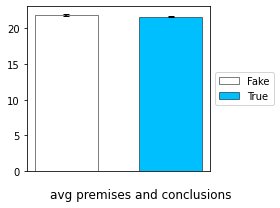

In [30]:
#plot: premises and conclusions

#create one subplot
fig, ax1 = plt.subplots(1, 1, figsize=(4 , 3))

#plot the bar for the avg premises and conclusions of the Fake news
ax1.bar(0,
                    np.mean(df_Fake_text['premises_conclusions']),
                    yerr=bootstrap_std(df_Fake_text['premises_conclusions'], 1000),
                    width=width,
                    label='Fake',
                    color=color_Fake,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
  )

#plot the bar for the avg premises and conclusions of the True news
ax1.bar(width + distance,
                    np.mean(df_True_text['premises_conclusions']),
                    yerr=bootstrap_std(df_True_text['premises_conclusions'], 1000),
                    width=width,
                    label='True',
                    color=color_True,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
)


#remove x_axis ticks 
ax1.set_xticks([])


#add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#set plot title
fig.suptitle('avg premises and conclusions', y=0)

plt.tight_layout()
plt.show()

The two types of news have on average the same number of premises and conclusions. We perform a statitical test to check if the diffrence is significant.

In [31]:
print("normal test on the premises and conclusions of Fake news:",stats.normaltest(df_Fake_text['premises_conclusions']))
print("normal test on the premises and conclusions of True news:",stats.normaltest(df_True_text['premises_conclusions']))

normal test on the premises and conclusions of Fake news: NormaltestResult(statistic=27775.053000913264, pvalue=0.0)
normal test on the premises and conclusions of True news: NormaltestResult(statistic=8669.742490914217, pvalue=0.0)


Both normal tests gave zero p_values, thus the null hypothesis can be rejected. They both come from a normal distribution. Now we will check if they have the same variance.

In [32]:
print("variance test:", levene(df_Fake_text['premises_conclusions'], df_True_text['premises_conclusions'] ))

variance test: LeveneResult(statistic=168.4026639741178, pvalue=1.9529330929375062e-38)


The levene test gave a significant p_value (<0.05), thus the two sets do not have equal variances. Since we have two normal distributions with diffrent variances, we use a Welch's t-test.

In [33]:
print("Welch's t-test:", stats.ttest_ind(df_Fake_text['premises_conclusions'], df_True_text['premises_conclusions'], equal_var = False))

Welch's t-test: Ttest_indResult(statistic=1.1030311898883463, pvalue=0.2700199201752161)


The Welch's t-test resulted in a large p_value(>0.05), then we cannot reject the null hypothesis of equal averages.

### Subjectivity plots

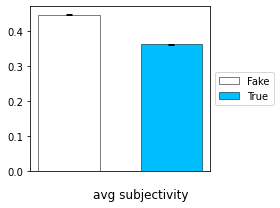

In [34]:
#plot: subjectivity

#create one subplot
fig, ax1 = plt.subplots(1, 1, figsize=(4 , 3))

#plot the bar for the avg subjectivity of the Fake news
ax1.bar(0,
                    np.mean(df_Fake_text['subjectivity']),
                    yerr=bootstrap_std(df_Fake_text['subjectivity'], 1000),
                    width=width,
                    label='Fake',
                    color=color_Fake,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
  )

#plot the bar for the avg subjectivity of the True news
ax1.bar(width + distance,
                    np.mean(df_True_text['subjectivity']),
                    yerr=bootstrap_std(df_True_text['subjectivity'], 1000),
                    width=width,
                    label='True',
                    color=color_True,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
)


#remove x_axis ticks 
ax1.set_xticks([])


#add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#set plot title
fig.suptitle('avg subjectivity', y=0)

plt.tight_layout()
plt.show()

The Fake news are on avergae more subejctive than the True news. 
This feature can be useful for detecting Fake news.

### Expansion, contingency and comparison plots 

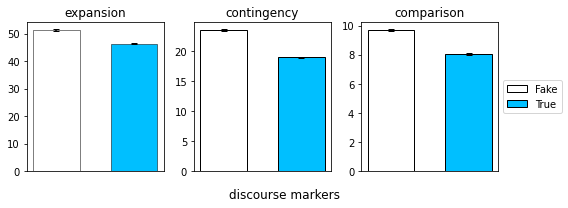

In [35]:
#labels for the plots
labels=['Fake ' , 'True']

#colors
color_Fake = 'white'
color_True= 'deepskyblue'

#distance between the two bars in the plot
distance=0.3

#width of the bar
width = 0.45

#create 3 subplots for the 3 graphs
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8 , 3))

#first plot: discourse expansion 

#plot the bar for the avg discourse expansion of the Fake news
ax1.bar(0,
                    np.mean(df_Fake_text['expansion']),
                    yerr=bootstrap_std(df_Fake_text['expansion'], 1000),
                    width=width,
                    label='Fake',
                    color=color_Fake,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
  )

#plot the bar for the avg discourse expansion of the True news
ax1.bar(width+distance ,
                    np.mean(df_True_text['expansion']),
                    yerr=bootstrap_std(df_True_text['expansion'], 1000),
                    width=width,
                    label='True',
                    color=color_True,
                    linewidth=0.5,
                    edgecolor='black',
                    capsize=3
)


#remove x_axis ticks and set the title
ax1.set_xticks([])
ax1.set_title('expansion')



#second plot: discourse contingency

#plot the bar for the avg discourse contingency of the Fake news
ax2.bar(0,
                    np.mean(df_Fake_text['contingency']),
                    yerr=bootstrap_std(df_Fake_text['contingency'],1000),
                    width=width,
                    color=color_Fake,
                    label='Fake',
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )

#plot the bar for the avg discourse contingency of the True news
ax2.bar(width+distance,
                    np.mean(df_True_text['contingency']),
                    yerr=bootstrap_std(df_True_text['contingency'],1000),
                    width=width,
                    color= color_True,
                    label='True' , 
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )

#remove x_axis ticks and set the title
ax2.set_xticks([])
ax2.set_title('contingency')



#Third plot: discourse comparison

#plot the bar for the avg discourse comparison of the Fake news
ax3.bar(0,
                    np.mean(df_Fake_text['comparaison']),
                    yerr=bootstrap_std(df_Fake_text['comparaison'],1000),
                    width=width,
                    color=color_Fake,
                    label='Fake',
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )

#plot the bar for the avg discourse comparison of the True news
ax3.bar(width+distance,
                    np.mean(df_True_text['comparaison']),
                    yerr=bootstrap_std(df_True_text['comparaison'],1000),
                    width=width,
                    color= color_True,
                    label='True' , 
                    linewidth=1,
                    edgecolor='black',
                    capsize=3 )
#remove x_axis ticks and set the title
ax3.set_xticks([])
ax3.set_title('comparison')

#add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#set plot title
fig.suptitle('discourse markers', y=0)
#plt.title('avg Sentiments', x=0, y=0)
plt.tight_layout()
plt.show()

On avergae contain more expansion, contingency and comparison discourse connectors than the True news. This shows that True news are less eloquant than Fake news.

Now that we analysed the features, we will run a classification model using them as input and check the performance.

## Classification with MLP (Multi-Layer Perceptron)

In this section, we want to classify the fake and True news using the features we have collected. 
The objective here is to verify if the "Linguistic harbringers of betrayal" model generalizes to other datasets.
We only retain the features that have been computed for all the dataset and that have been used by the author for homogenity. We thus remove the following features: 
* text
* parses
* tot_sentiments
* average_sentiment
* positive_Sentiment
* negative_Sentiment
* neutral_Sentiment

In [36]:
# We add the labels for the True News that we set to one
df_True_text["label"] = np.ones(len(df_True_text))

# We add the labels for the Fake News that we set to zero
df_Fake_text["label"] = np.zeros(len(df_Fake_text))

# We create a full dataset and we drop unused features
X = pd.concat([df_Fake_text, df_True_text]).drop(columns=["text",  "parses", "tot_sentiments", "avg_sentiment", "positive_Sentiment", "negative_Sentiment", "neutral_Sentiment"])
X.sample(5)

,nb_sentences,nb_words,politeness,premises_conclusions,subjectivity,polarity,comparaison,contingency,expansion,label
15151,14.0,507.0,0.491815,27,0.496941,0.059933,11,25,62,0.0
17184,10.0,246.0,0.453200,15,0.433654,0.112843,6,12,34,0.0
19245,36.0,857.0,0.463926,37,0.389757,-0.012535,21,44,119,1.0
15651,25.0,625.0,0.467116,42,0.473980,0.119983,15,38,87,1.0
7243,17.0,506.0,0.488818,46,0.508408,0.166389,10,20,60,1.0


In [37]:
# We scale the data with the z_score scaling
X_norm = X.drop(columns=["label"])
X_norm = (X_norm - X_norm.mean(axis=0))/X_norm.std(axis=0)

# We finally split the data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_norm, X["label"])

In [38]:
# We build a model with 16 neurones as input layer, 
# 256 neurones for the first hidden layer, 
# 64 neurones for the second hidden layer, 
# 1 neurone for the last layer that is going to provide the output.
# We add early stopping and l2 regularization to avoid overfitting.
clf = MLPClassifier([256, 64], verbose=True, early_stopping=True, alpha=0.001)

#train the model
clf.fit(X_train, y_train)

Iteration 1, loss = 0.53026470
Validation score: 0.757245
Iteration 2, loss = 0.46566083
Validation score: 0.778124
Iteration 3, loss = 0.45035393
Validation score: 0.775008
Iteration 4, loss = 0.44066567
Validation score: 0.781864
Iteration 5, loss = 0.43286157
Validation score: 0.786226
Iteration 6, loss = 0.42998827
Validation score: 0.791835
Iteration 7, loss = 0.42524670
Validation score: 0.782487
Iteration 8, loss = 0.42232007
Validation score: 0.799626
Iteration 9, loss = 0.41759476
Validation score: 0.791835
Iteration 10, loss = 0.41553619
Validation score: 0.796510
Iteration 11, loss = 0.41305826
Validation score: 0.797445
Iteration 12, loss = 0.41054756
Validation score: 0.798691
Iteration 13, loss = 0.41071686
Validation score: 0.794640
Iteration 14, loss = 0.40794193
Validation score: 0.797756
Iteration 15, loss = 0.40722591
Validation score: 0.802742
Iteration 16, loss = 0.40359211
Validation score: 0.800249
Iteration 17, loss = 0.40173745
Validation score: 0.796198
Iterat

MLPClassifier(alpha=0.001, early_stopping=True, hidden_layer_sizes=[256, 64],
              verbose=True)

In [39]:
# We print the test accuracy
print("test accuracy:", clf.score(X_test, y_test))

test accuracy: 0.8205871353777113


Text(0.5, 1.0, '2-class Precision-Recall curve')

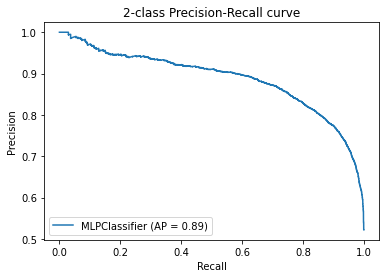

In [40]:
# We predict the labels for the test set
y_score = clf.predict(X_test)

# We plot the precision recall curve
disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve')

The Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds. We see that the model performs well as we got an average precison of 87% and it has a considerable AUC (Area Under the Curve).